# Part 6 - Predicting Review Classifications

## Tasks
For this part of the project, you will using machine learning and deep NLP to classify the reviews.
### Repo Prep


- Create a `"Models/"` folder in your project repository, with the following sub-folders: 
    - `"Models/ml/"`. You will save your sklearn model pipelines here for later use in deployment.
    - `"Models/nn/"`. You will save your tensorflow models here for later use in deployment.
- Add new subfolders to your "Data-NLP/"" folder.
    - Specifically, create:
        - `"Data-NLP/ml/"` folder. We will save your training and test data (X_train,y_train) for later use in deployment.
        - `"Data-NLP/nn/"` folder.  We will save your training and test Tensorflow datasets for later use in deployment.
     

    
- Create a new notebook for Part 6 - Review Classification for this part of the project. 

### Load the Data

- Load the joblib containing the dataframe from Part 5 of the project.
- Use the original review column as X and the classiifcation target (High/Low Rating Reviews) as y.

___

## Machine Learning
For this project, you will use modeling pipelines with the text vectorizer and model in the same pipeline. This will make it very easy to use save and load the models to use in a deployed application.


### Create a Text Vectorizer
- Select an sklearn vectorizer to for your task.
    - Remember to consider your preprocessing choices like using stopwords, using ngrams, etc.

### Build a Machine Learning Model

- Build an sklearn modeling pipeline with a text vectorizer and a classification model.
    - Suggested Models: MultinomialNB, LogisticRegression, RandomForestClassifier 

- Fit and evaluate the model using the machine learning classification models from sklearn.
    - In a Markdown cell, document your observations from your results. (e.g. how good is the model overall? Is it particularly good/bad at predicting one class?)


### GridSearch Text Vectorization 
Attempt to improve on yourm model by tuning the text preprocessing steps. 

- Construct a grid of parameters for the text vectorization step. Consider trying:
    - CountVectorizer/TfidfVectorizer
    - stopwords
    - ngram_range
    - min_df/max_df

- Fit and evaluate the gridsearch results:
    - What were the best parameters?
    - How does the best estimator perform when evaluated on the training and test data?
 

### Save the Best Model and Train/Test Data  as Joblibs

- Save your overall best model pipeline as the only variable in a .joblib file in your new Models/ folder. (e.g. "Models/ml/best-clf-logreg.joblib")

- Save a list containing `[X_train, y_train]` as `"Data-NLP/ml/train-data.joblib"`
- Save a list containing `[X_test,y_test]`  as `"Data-NLP/ml/test-data.joblib"`


____

## Deep NLP (RNNs)
For this part of the project, you will use a Keras TextVectorization layer as part of your RNN model. This serves the same purpose as using the sklearn pipeline: it bundles text preparation into the model itself, making it deployment-ready.

 
###  Create train/test/val datasets
- Convert the target categories to integers (e.g. Using sklearn's LabelEncoder) 
- Create a tensorflow dataset using the X and  (integer version) of y.
- Split the dataset into a training, test, and validation datasets.

### Create a Keras Text Vectorization layer
- Create a keras text vectorization layer to use in an RNN (sequence) model.
- Fit/Adapt the text vectorization layer on the training texts.
- Save the vocabulary size from layer to use in your models' Embedding layer.


### Build an RNN with the TextVectorization Layer
- Build and fit at least 1 sequence model (LSTM, GRU, Bidirectional, etc)
- Evalaute the model on the training and trest data.
    - In a Markdown cell, document your observations from your results. (e.g. How did the RNN compare to your ML model? Was it superior to your ML model in some way (e.g. accuracy, recall, etc.)


### Save your best RNN model and Tensforflow Datasets

- Save your best neural network in a subfolder inside your `"Models/nn/` folder. (e.g. "Models/nn/lstm/")
    - Reminder: use safe_format='tf' to save the model in a folder of repo-friendly files. 

- Save your training and test Tensorflow dataset objects in "Data/nn/":
    - Save your training dataset object as `"Data-NLP/nn/train/"`
    - Save your test dataset object  as `"Data-NLP/nn/test/"`"



### 


In [3]:
import json
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS

{'data': {'raw': {'movie-reviews': 'Data-NLP/tmdb-movie-reviews.csv.gz',
   'movie-info': 'Data-NLP/tmdb-movie-info.csv.gz',
   'eda': 'Data-NLP/eda-movie-reviews.csv.gz',
   'processed-joblib': 'Data/processed-nlp-data.joblib'},
  'ml': {'train': 'Data-NLP/training-data.joblib',
   'test': 'Data-NLP/testing-data.joblib'},
  'nn': {'train': 'data/training-data-tf/', 'test': 'data/testing-data-tf/'}},
 'models': {'ml': {'bayes': 'Models/bayes-clf.joblib',
   'random_forest': 'Models/random-forest.joblib',
   'logreg': 'Models/log-reg.joblib'},
  'nn': {'LSTM': 'Models/keras/lstm/',
   'GRU': 'Models/keras/gru/',
   'Attention': 'Models/keras/attn/'}},
 'images': {'banner': 'images/app-banner.png'},
 'metadata': {'target_lookup': 'Data-NLP/target-lookup.json'},
 'eda': {'wordclouds': 'EDA/wordcloud-comparison.png',
  'scattertext': 'EDA/scattertext.html'}}

# Code

In [4]:
## Run code to get reproducible results BEFORE anything else
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# Source: https://discuss.tensorflow.org/t/upgrading-os-to-sonoma-on-my-mac-causing-tensorflow-errors/19846/5
tf.config.set_visible_devices([], 'GPU')

In [5]:
%load_ext autoreload
%autoreload 2

import project_functions as fn
# import custom_functions as fn

In [6]:
# !pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.0'

In [7]:
import os
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
## Making New Folders 
# dirs = ["Data/",'Data/ml/',"Models/","Models/keras/"]
# for folder in dirs:
#     os.makedirs(folder, exist_ok=True)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from sklearn import set_config
set_config(transform_output='pandas')


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## #NOT THE MOST RECENT VERSIONS!!!!
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


## Load Data (Options)

### Opt A) CSV

In [9]:
df =  pd.read_csv('Data-NLP/combined-tmdb-movie-reviews.csv.gz')
df

,movie_id,review_id,rating,review_text,created_at
0,843,64ecc16e83901800af821d50,7.0,This is a fine piece of cinema from Wong Kar-W...,2023-08-28 15:46:55.026000+00:00
1,7443,57086ff5c3a3681d29001512,9.0,"A guilty pleasure for me personally, as I love...",2016-04-09 02:59:01.116000+00:00
2,7443,5bb5ac829251410dcb00810c,6.0,Made my roommate who hates stop-motion animati...,2018-10-04 06:00:34.227000+00:00
3,7443,5f0c53a013a32000357ec505,8.0,A very good stop-motion animation!\r\n\r\n<em>...,2020-07-13 12:29:20.853000+00:00
4,7443,64ecc027594c9400ffe77c91,7.0,"Ok, there is an huge temptation to riddle this...",2023-08-28 15:41:27.525000+00:00
...,...,...,...,...,...
9019,572802,6584672cf1759c3f51118a1e,6.0,FULL SPOILER-FREE REVIEW @ https://fandomwire....,2023-12-21 16:26:21.038000+00:00
9020,572802,65882401688cd057b284dd8f,6.0,"So here's good old ""Arthur"" (Jason Momoa) sitt...",2023-12-24 12:28:49.987000+00:00
9021,1072342,659750cfea37e006fa4d0ab1,NaN,The first major release of 2024 has arrived in...,2024-01-05 00:43:59.378000+00:00
9022,1072342,659af41eca4f6701fe77183c,3.0,FULL SPOILER-FREE REVIEW @ https://fandomwire....,2024-01-07 18:57:34.390000+00:00


### Opt B) Previously Processed Joblib

In [10]:
import joblib
# fname_data_joblib = "Data/processed-nlp-data.joblib"
fname_data_joblib = FPATHS['data']['raw']['processed-joblib']
df = joblib.load(fname_data_joblib)
df

,movie_id,review_id,rating,review_text,created_at,target,length,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined
0,100042,64a3999fe9da6900c763aa8d,7.0,Better then the original I think. Was pretty f...,2023-07-04 04:01:35.517000+00:00,<NA>,19,"[better, then, the, original, i, think, was, p...","[better, original, think, pretty, funny, thoug...","[well, original, think, pretty, funny, think, ...",better then the original i think was pretty fu...,better original think pretty funny thought com...,well original think pretty funny think comedy ...
1,10008,643d44864d67910469d853a2,5.0,Kind of boring. It's a good plot and storyline...,2023-04-17 13:07:18.832000+00:00,<NA>,15,"[kind, of, boring, it, 's, a, good, plot, and,...","[kind, boring, good, plot, storyline, interested]","[kind, boring, good, plot, storyline, interested]",kind of boring it 's a good plot and storyline...,kind boring good plot storyline interested,kind boring good plot storyline interested
2,10009,5f22bd2b43999b00355b26a6,7.0,"Heartwarming, if not as impactful as it intend...",2020-07-30 12:29:31.310000+00:00,<NA>,140,"[heartwarming, if, not, as, impactful, as, it,...","[heartwarming, impactful, intends, \r\n\r\n, <...","[heartwarme, impactful, intend, \r\n\r\n, <, e...",heartwarming if not as impactful as it intends...,heartwarming impactful intends \r\n\r\n < em>'...,heartwarme impactful intend \r\n\r\n < em>'Bro...
3,10012,628159c8caa50850dcf93d33,5.0,Seems like an apt title for everything that ha...,2022-05-15 19:51:36.244000+00:00,<NA>,77,"[seems, like, an, apt, title, for, everything,...","[like, apt, title, happened, scenes, justice, ...","[like, apt, title, happen, scene, Justice, Lea...",seems like an apt title for everything that ha...,like apt title happened scenes justice league ...,like apt title happen scene Justice League cos...
4,10016,636cb0040499f200cd3c8f60,5.0,"Frankly, this could have been set anywhere, bu...",2022-11-10 08:02:12.893000+00:00,<NA>,227,"[frankly, this, could, have, been, set, anywhe...","[frankly, set, mars, late, 22nd, century, venu...","[frankly, set, Mars, late, 22nd, century, venu...",frankly this could have been set anywhere but ...,frankly set mars late 22nd century venue slice...,frankly set Mars late 22nd century venue slice...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,99861,5c842655c3a3684e95db3e38,5.0,The fact that Joss Whedon was able to salvage ...,2019-03-09 20:47:17.431000+00:00,<NA>,159,"[the, fact, that, joss, whedon, was, able, to,...","[fact, joss, whedon, able, salvage, sort, cohe...","[fact, Joss, Whedon, able, salvage, sort, cohe...",the fact that joss whedon was able to salvage ...,fact joss whedon able salvage sort coherent fi...,fact Joss Whedon able salvage sort coherent fi...
8674,99861,5ef819bba284eb00398dc810,7.0,Third viewing of this and while not the strong...,2020-06-28 04:16:59.341000+00:00,<NA>,66,"[third, viewing, of, this, and, while, not, th...","[viewing, strongest, mcu, avenger, movies, goo...","[viewing, strong, MCU, Avenger, movie, good, p...",third viewing of this and while not the strong...,viewing strongest mcu avenger movies good part...,viewing strong MCU Avenger movie good part int...
8675,99861,600616349a358d0040c2ecad,7.0,"Cool seeing them all together again, even if I...",2021-01-18 23:13:56.078000+00:00,<NA>,196,"[cool, seeing, them, all, together, again, eve...","[cool, seeing, massively, enjoy, good, opinion...","[cool, see, massively, enjoy, good, opinion, \...",cool seeing them all together again even if i ...,cool seeing massively enjoy good opinion \r\n\...,cool see massively enjoy good opinion \r\n\r\n...
8676,9988,5a6940bc9251414a2e009179,5.0,"Not one of Broken Lizard's strongest entries, ...",2018-01-25 02:28:12.494000+00:00,<NA>,34,"[not, one, of, broken, lizard, 's, strongest, ...","[broken, lizard, strongest, entries, classic, ...","[Broken, Lizard, strong, entry, classic, viewi...",not one of broken lizard 's strongest e

## Define df_ml

In [7]:
# Dropping Reviews not in target ratings
df_ml = df.dropna(subset=['target'])
df_ml

,movie_id,review_id,rating,review_text,created_at,target,length,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined
8,1003578,62dd7246ea84c7004fc691e5,10.0,"Very enertaining movie. Action, adventure, com...",2022-07-24 16:24:38.268000+00:00,High,15,"[very, enertaining, movie, action, adventure, ...","[enertaining, movie, action, adventure, comedy...","[enertaining, movie, action, adventure, comedy...",very enertaining movie action adventure comedy...,enertaining movie action adventure comedy grea...,enertaining movie action adventure comedy grea...
10,100402,53f4879b0e0a267f8d001da8,9.0,This is indeed a great piece of superhero ente...,2014-08-20 11:33:47.053000+00:00,High,406,"[this, is, indeed, a, great, piece, of, superh...","[great, piece, superhero, entertainment, super...","[great, piece, superhero, entertainment, super...",this is indeed a great piece of superhero ente...,great piece superhero entertainment superheroe...,great piece superhero entertainment superhero ...
13,100402,55e43b63c3a368418e0035a3,9.0,Till the end of the road.\r\n\r\nStonking! Now...,2015-08-31 11:32:51.183000+00:00,High,246,"[till, the, end, of, the, road, \r\n\r\n, ston...","[till, end, road, \r\n\r\n, stonking, like, di...","[till, end, road, \r\n\r\n, stonke, like, disa...",till the end of the road \r\n\r\n stonking now...,till end road \r\n\r\n stonking like disappoin...,till end road \r\n\r\n stonke like disappointm...
14,100402,5a2ccb3ac3a3680b8f145cdc,9.0,**A long format review from 2014**\r\n\r\nMisl...,2017-12-10 05:50:50.967000+00:00,High,408,"[a, long, format, review, from, 2014, \r\n\r\n...","[long, format, review, 2014, \r\n\r\n, mislead...","[long, format, review, 2014, \r\n\r\n, mislead...",a long format review from 2014 \r\n\r\n mislea...,long format review 2014 \r\n\r\n misleadingly ...,long format review 2014 \r\n\r\n misleadingly ...
15,100402,5c842694c3a3684e8cdacb97,9.0,Captain America: The Winter Soldier opens up w...,2019-03-09 20:48:20.066000+00:00,High,126,"[captain, america, the, winter, soldier, opens...","[captain, america, winter, soldier, opens, act...","[Captain, America, Winter, soldier, open, acti...",captain america the winter soldier opens up wi...,captain america winter soldier opens action se...,Captain America Winter soldier open action seq...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,994143,643e03b7c6006d0315805f72,10.0,The only way for this movie to wow you is to g...,2023-04-18 02:43:03.516000+00:00,High,348,"[the, only, way, for, this, movie, to, wow, yo...","[way, movie, wow, respect, ultimately, movie, ...","[way, movie, wow, respect, ultimately, movie, ...",the only way for this movie to wow you is to g...,way movie wow respect ultimately movie okay \r...,way movie wow respect ultimately movie okay \r...
8623,9955,60e9f22e2efe4e0075b906b0,4.0,"Frustrating watch, won't watch again, and can'...",2021-07-10 19:17:02.136000+00:00,Low,190,"[frustrating, watch, wo, n't, watch, again, an...","[frustrating, watch, wo, watch, recommend, \r\...","[frustrating, watch, will, watch, recommend, \...",frustrating watch wo n't watch again and ca n'...,frustrating watch wo watch recommend \r\n\r\n ...,frustrating watch will watch recommend \r\n\r\...
8628,9966,5f641a101684f70036425926,4.0,"Bad watch, probably won't watch again, and can...",2020-09-18 02:23:12.114000+00:00,Low,341,"[bad, watch, probably, wo, n't, watch, again, ...","[bad, watch, probably, wo, watch, recommend, \...","[bad, watch, probably, will, watch, recommend,...",bad watch probably wo n't watch again and ca n...,bad watch probably wo watch recommend \r\n\r\n...,bad watch probably will watch recommend \r\n\r...
8629,9966,61916225f85958002b72a60c,4.0,_**Little Haunted House on the Prairie**_\r\n\...,2021-11-14 19:23:17.903000+00:00,Low,195,"[little, haunted, house, on, the, prairie, \r\...","[little, haunted, house, prairie, \r\n\r\n, tr...","[Little, Haunted, House, Prairie, \r\n\r\n, tr...",little haunted h

In [8]:
df_ml['target'].value_counts(1)

Low     0.506008
High    0.493992
Name: target, dtype: float64

In [9]:
X = df_ml['review_text']
y = df_ml['target']

In [10]:
# Disable parser and ner
# nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)
X_train.head()

1511    My wife picked this one up together with the w...
551     **The curse of video game movies.**\r\n\r\nRea...
5221    Mortal Kombat is not just too long for a movie...
3608    Baby (Elgort) is a quiet, unassuming young man...
2401    Really funny. I die laughing everytime I watch...
Name: review_text, dtype: object

In [12]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_bayes = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',MultinomialNB())
])
vectorizer.fit(X_train)

CountVectorizer()

In [13]:
# Saves vocab - matches number of columns above
vocab_dict = vectorizer.vocabulary_
len(vocab_dict)

22288

In [14]:
# Words are now the feature_names
feature_names = vectorizer.get_feature_names_out()
len(feature_names)

22288

In [15]:
FPATHS

{'data': {'raw': {'movie-reviews': 'Data-NLP/tmdb-movie-reviews.csv.gz',
   'movie-info': 'Data-NLP/tmdb-movie-info.csv.gz',
   'eda': 'Data-NLP/eda-movie-reviews.csv.gz',
   'processed-joblib': 'Data/processed-nlp-data.joblib'},
  'ml': {'train': 'Data-NLP/training-data.joblib',
   'test': 'Data-NLP/testing-data.joblib'},
  'nn': {'train': 'data/training-data-tf/', 'test': 'data/testing-data-tf/'}},
 'models': {'ml': {'bayes': 'Models/bayes-clf.joblib',
   'random_forest': 'Models/random-forest.joblib',
   'logreg': 'Models/log-reg.joblib'},
  'nn': {'LSTM': 'Models/keras/lstm/',
   'GRU': 'Models/keras/gru/',
   'Attention': 'Models/keras/attn/'}},
 'images': {'banner': 'images/app-banner.png'},
 'metadata': {'target_lookup': 'Data-NLP/target-lookup.json'},
 'eda': {'wordclouds': 'EDA/wordcloud-comparison.png',
  'scattertext': 'EDA/scattertext.html'}}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       830
         Low       1.00      1.00      1.00       855

    accuracy                           1.00      1685
   macro avg       1.00      1.00      1.00      1685
weighted avg       1.00      1.00      1.00      1685



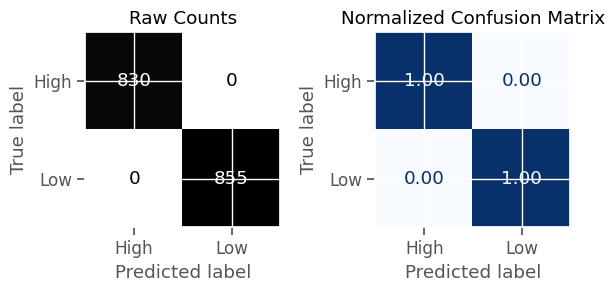


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.82      0.86      0.84       280
         Low       0.85      0.81      0.83       282

    accuracy                           0.84       562
   macro avg       0.84      0.84      0.84       562
weighted avg       0.84      0.84      0.84       562



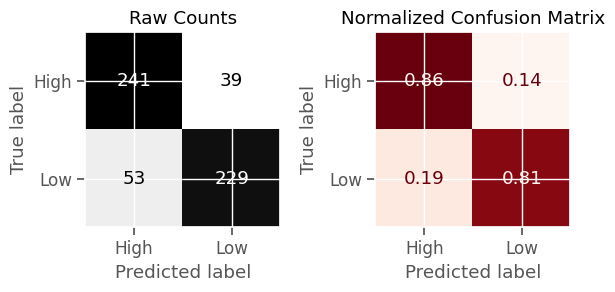

['Models/log-reg.joblib']

In [16]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
fn.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.98      0.98      0.98       830
         Low       0.98      0.98      0.98       855

    accuracy                           0.98      1685
   macro avg       0.98      0.98      0.98      1685
weighted avg       0.98      0.98      0.98      1685



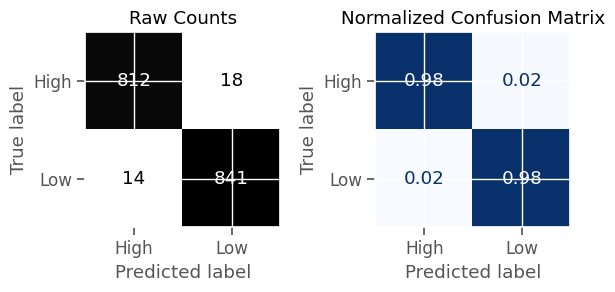


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.89      0.84      0.86       280
         Low       0.85      0.89      0.87       282

    accuracy                           0.87       562
   macro avg       0.87      0.87      0.87       562
weighted avg       0.87      0.87      0.87       562



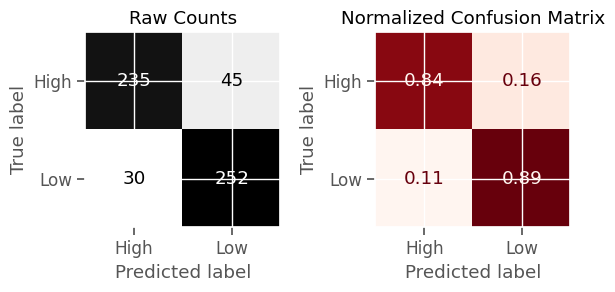

['Models/bayes-clf.joblib']

In [17]:
## Fit an evaluate a Naive Bayes Classifier
clf_bayes.fit(X_train, y_train)
fn.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes'])

In [18]:
FPATHS['models']['ml']['random_forest']

'Models/random-forest.joblib'

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       830
         Low       1.00      1.00      1.00       855

    accuracy                           1.00      1685
   macro avg       1.00      1.00      1.00      1685
weighted avg       1.00      1.00      1.00      1685



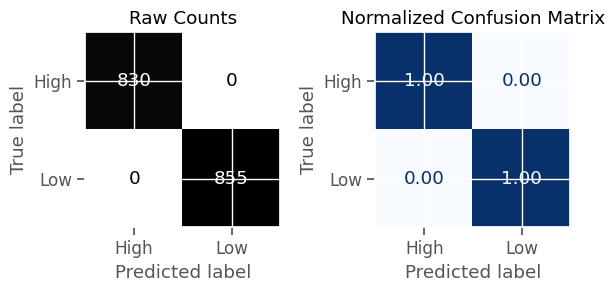


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.81      0.86      0.84       280
         Low       0.86      0.80      0.83       282

    accuracy                           0.83       562
   macro avg       0.83      0.83      0.83       562
weighted avg       0.83      0.83      0.83       562



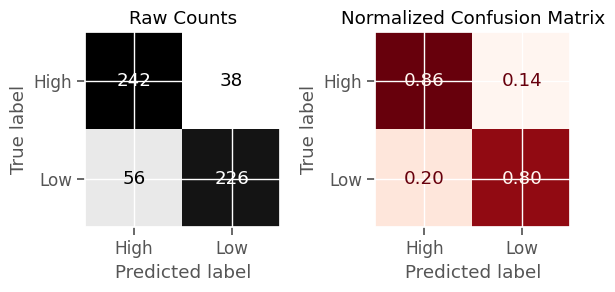

['Models/random-forest.joblib']

In [19]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier())
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
fn.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest'])

## GridSearching ML Models/Prep

In [20]:
# # Define params to try for both vectorizers
# # param_grid_clf = {'clf__C': [1e12,1e10]}

# param_grid_shared = {
#     "vectorizer__max_df": [0.7, 0.8, 0.9],
#     'vectorizer__min_df': [ 2, 3, 4 ], 
#     # "vectorizer__max_features": [None, 1000, 2000],
#     "vectorizer__stop_words": [None,'english']
# }

# # Setting params for the count vectorizer
# param_grid_count = {
#     'vectorizer':[CountVectorizer()],
#     **param_grid_shared
# }


# # Setting params for tfidf vectorizer 
# param_grid_tfidf = {
#     'vectorizer': [TfidfVectorizer()],
#     "vectorizer__norm": ["l1", "l2"],
#     "vectorizer__use_idf": [True, False],
#     **param_grid_shared
# }

# # combine into list of params
# params_combined = [param_grid_count, param_grid_tfidf]
# params_combined

In [21]:
# # logreg_pipe = Pipeline([
# #     ('vectorizer',TfidfVectorizer()),
# #     ('clf',LogisticRegression(max_iter=500))
# # ])

# logreg_pipe = Pipeline([
#     ('vectorizer',CountVectorizer()),
#     ('clf',MultinomialNB())
# ])


In [22]:
# %%time
# # Create grid search
# grid_search = GridSearchCV(logreg_pipe, params_combined, scoring='recall_macro',cv=3, verbose=1, n_jobs=-1)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)


In [23]:
# grid_search.best_params_


In [24]:
# # Now define the best version of the model
# best_model = grid_search.best_estimator_

# # Predict and Evaluate with the custom function
# fn.evaluate_classification(best_model, X_train, y_train, X_test, y_test)


## GS from LP

In [25]:
# param_grid_shared = {
#     "vectorizer__max_df": [0.7, 0.8, 0.9],
#     'vectorizer__min_df': [ 2, 3, 4 ], 
#     # "vectorizer__max_features": [None, 1000, 2000],
#     "vectorizer__stop_words": [None,'english']
# }

# # Setting params for the count vectorizer
# param_grid_count = {
#     'vectorizer':[CountVectorizer()],
#     **param_grid_shared
# }


# # Setting params for tfidf vectorizer 
# param_grid_tfidf = {
#     'vectorizer': [TfidfVectorizer()],
#     "vectorizer__norm": ["l1", "l2"],
#     "vectorizer__use_idf": [True, False],
#     **param_grid_shared
# }


# # Define parameters to tune multiple models

# param_grid_RF = {
#     'clf' : [RandomForestClassifier(random_state = 42)],
#     'clf__max_depth' : [5, None],
#     'clf__min_samples_leaf' : [1, 2],
# }

# param_grid_MNB = {
#     'clf' : [MultinomialNB()],
#     'clf__alpha' : [.5, 1],
# }

# param_grid_logreg = {
#     'clf': [LogisticRegression(random_state = 42)],
#     'clf__C' : [.1, 1, 10, 100],
# }

# # combine into list of params
# model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]




In [26]:
# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), # This is just a placeholder
                     ('clf',MultinomialNB())])



In [27]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]



In [28]:
# Define parameters to tune multiple models

# param_grid_RF = {
#     'clf' : [RandomForestClassifier(random_state = 42)],
#     'clf__max_depth' : [20, None],
#     'clf__min_samples_leaf' : [1, 2],
# }

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(max_iter=500,random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [
    # param_grid_RF,
    param_grid_MNB, 
    param_grid_logreg]

In [29]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [MultinomialNB()], 'clf__alpha': [0.5, 1]})

In [30]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [MultinomialNB()],
 'clf__alpha': [0.5, 1]}

In [31]:
# %%time
## TEMP: COMPARE TIMING IF n_jobs is NOT -1
# # Create grid search
# grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1)#, n_jobs=-1)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [32]:
%%time
SKIP = False

if not SKIP:
    # Create grid search
    grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
        
        
    # Fit the model
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
{'clf': MultinomialNB(alpha=1), 'clf__alpha': 1, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2), 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 2, 'vectorizer__norm': 'l2', 'vectorizer__stop_words': None, 'vectorizer__use_idf': True}
CPU times: user 13.3 s, sys: 8.58 s, total: 21.9 s
Wall time: 1min 36s


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.99      0.95      0.97       830
         Low       0.95      0.99      0.97       855

    accuracy                           0.97      1685
   macro avg       0.97      0.97      0.97      1685
weighted avg       0.97      0.97      0.97      1685



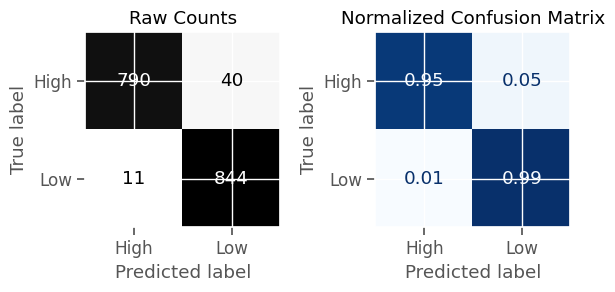


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.90      0.84      0.87       280
         Low       0.85      0.91      0.88       282

    accuracy                           0.87       562
   macro avg       0.87      0.87      0.87       562
weighted avg       0.87      0.87      0.87       562



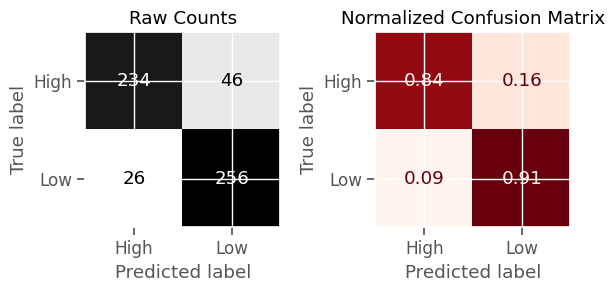

In [33]:
if not SKIP:
    
    # Now define the best version of the model
    best_model = grid_search.best_estimator_
    
    # Predict and Evaluate with the custom function
    fn.evaluate.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### Saving ML Model & Data

In [34]:

# Save training data
fpath_train_joblib = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train],fpath_train_joblib)

# Save test data
fpath_test_joblib = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test],fpath_test_joblib)

# if not SKIP:
#     # Saving the best model 
#     fpath_best_ml_model  = "Models/best-ml-model.joblib"
#     joblib.dump(best_model, fpath_best_ml_model)

['Data-NLP/testing-data.joblib']

## 👉11/30/23 Brenda 1:1 - Admin Test/Demo

### Ngrams

In [35]:
#our pre-exting ngram df function https://login.codingdojo.com/m/692/16501/124388

import pandas as pd
def get_ngram_measures_finder(tokens, ngrams=2, get_scores_df=False, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

### Text Explainer

In [36]:
X_to_pred = 'It was the best move i had ever seen until the last 30 mins, which ruined the whole thing.'

In [37]:
y

8       High
10      High
13      High
14      High
15      High
        ... 
8621    High
8623     Low
8628     Low
8629     Low
8634    High
Name: target, Length: 2247, dtype: object

In [38]:
clf_bayes.predict([X_to_pred])

array(['Low'], dtype='<U4')

In [39]:
y.unique()

array(['High', 'Low'], dtype=object)

In [40]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=y.unique())
explanation = explainer.explain_instance(X_to_pred, clf_bayes.predict_proba)
explanation.show_in_notebook()

# Neural Networks

In [41]:
# raise

## ✅🚨 TO DO 11/30

- Write up tensorflow deployment lesson as I finalize model and dataset saving/loading 

In [42]:
def save_model(
    model=None,
    model_folder=None,
    overwrite=False,
    save_model_kws={},
    load_and_evaluate=True,
    train_ds=None,
    test_ds=None,
):
    ## allowing for JUST loading if no model and load_and_eval==True
    if (model == None) & (load_and_evaluate == None):
        raise Exception(
            "[!] Must either provide a model to save or sert load_and_evaluate to True to load only."
        )

    if model_folder == None:
        model_folder = "Models/model01/"

    # Create folder
    os.makedirs(model_folder, exist_ok=True)

    # Save Model. with keras.models.save_model
    try:
        tf.keras.models.save_model(model, model_folder, **save_model_kws)

    except Exception as e:
        print("[!] Save failed:")
        display(e)

    if load_and_evaluate == True:
        loaded = tf.keras.models.load_model(model_folder)
        display(
            fn.evaluate_classification_network(loaded, X_train=train_ds, X_test=test_ds)
        )  # , history=history);
        return loaded

In [43]:
from sklearn.preprocessing import LabelEncoder

In [44]:
# Define X and y
X = df_ml['review_text']
y_string= df_ml['target']

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y_string))
y.value_counts()

1    1137
0    1110
dtype: int64

In [45]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [46]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")



    - train:	1572 samples 	(50 batches)
    - val:  	449 samples 	(15 batches)
    - test: 	226 samples 	(8 batches)


In [47]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')



 There are 50 training batches.
 There are 15 validation batches.
 There are 8 testing batches.


In [48]:
# # taking a sample 
# example_X, example_y= train_ds.take(1).get_single_element()
# print(example_X)
# print(example_y)

In [49]:
## Saving Train and test dataset
fname_train_ds = FPATHS['data']['nn']['train']
train_ds.save(path=fname_train_ds,)

fname_test_ds = FPATHS['data']['nn']['test']
test_ds.save(path=fname_test_ds,)

2023-12-02 20:00:16.877353: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


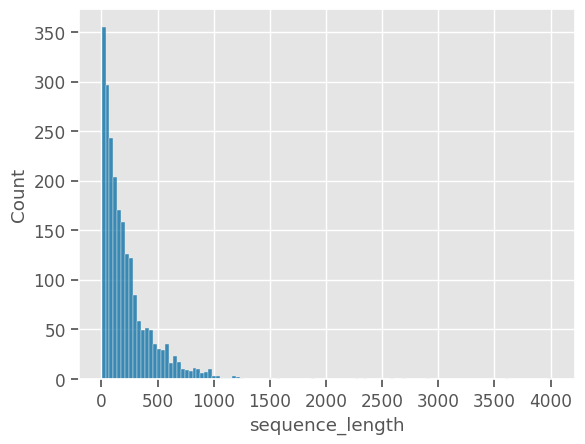

In [50]:
df_ml = df_ml.copy()
df_ml['sequence_length'] = df_ml['review_text'].map( lambda x: len(x.split(" ")))
ax = sns.histplot(df_ml['sequence_length'])

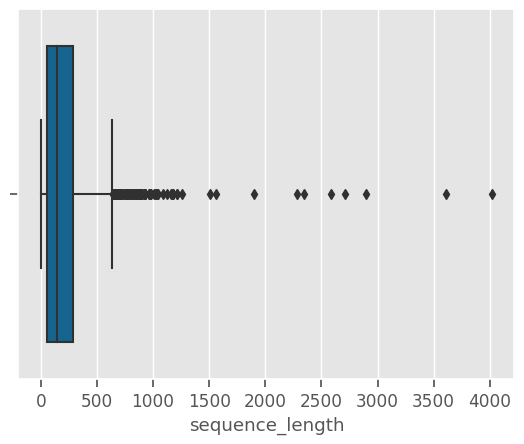

In [51]:
ax = sns.boxplot(data=df_ml, x='sequence_length')

In [52]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
# ds_texts.take(1).get_single_element()

In [53]:
SEQUENCE_LENGTH = 600
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)
sequence_vectorizer.adapt(ds_texts)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE


24132

In [54]:
# raise Exception("Update code below to use only what is shown on the LP")

#### LSTM

In [55]:
# Define a function for building an LSTM model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential

# @tf.function
def build_lstm_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )

    # Add *new* LSTM layer
    lstm_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    lstm_model.add(layers.Dropout(0.5))
    lstm_model.add(layers.Bidirectional(layers.LSTM(128)))#, return_sequences=True)))
    # lstm_model.add(layers.GlobalMaxPooling1D())

    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation="softmax"))

    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    lstm_model.compile(
        optimizer=optimizer,  #'adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    lstm_model.summary()
    return lstm_model

In [56]:
# # Code below is from CNN Week
# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, verbose=True)
#     return [early_stop]


### Call backs
# @tf.function
def get_callbacks(monitor='val_accuracy',patience=3, restore_best_weights=True,
                  start_from_epoch=0,baseline_value=None,
                  verbose_early_stopping=1,  
                  tensborboard=True, logdir="/tmp/tb_logs",
                 tb_embed_freq=0, tb_write_images = False, tb_hist_freq = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, #mode=mode, 
                                                      restore_best_weights=restore_best_weights,
                                                      baseline=baseline_value,
                                                      start_from_epoch=start_from_epoch,
                                                      verbose=verbose_early_stopping)

    if tensborboard:
        tboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=tb_hist_freq,write_images=tb_write_images,
                                                embeddings_freq=tb_embed_freq,)
        return [ early_stopping, tboard]
    else:
        return [early_stopping]

In [57]:
EMBED_DIM = 100
classes = y_train.unique()
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 600)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 600, 100)          2413200   
                                                                 
 bidirectional (Bidirectiona  (None, 600, 256)         234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 600, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                        

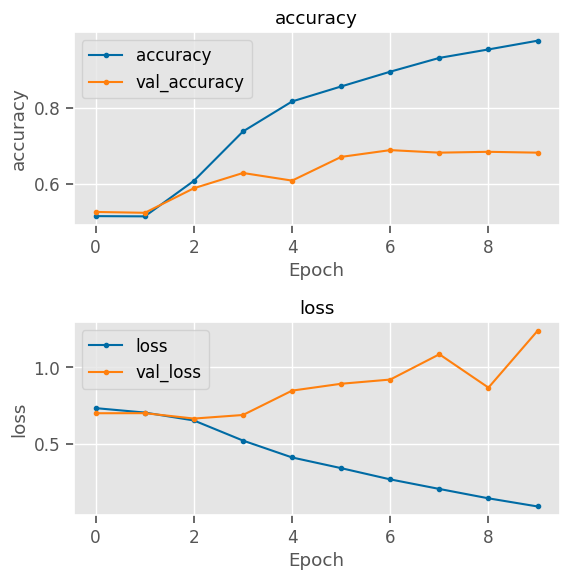


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       782
           1       0.97      0.93      0.95       790

    accuracy                           0.95      1572
   macro avg       0.95      0.95      0.95      1572
weighted avg       0.95      0.95      0.95      1572



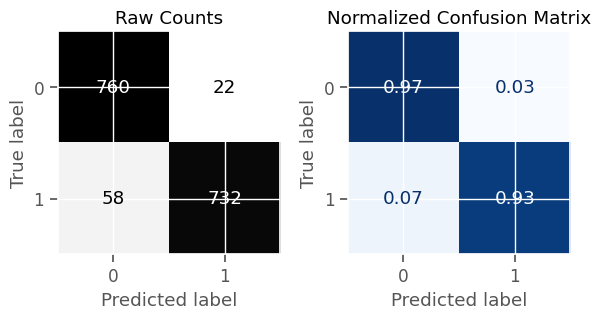


- Evaluating Training Data:
50/50 [==============================] - 34s 683ms/step - loss: 0.1503 - accuracy: 0.9491
{'loss': 0.15031781792640686, 'accuracy': 0.9491094350814819}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       111
           1       0.77      0.56      0.65       115

    accuracy                           0.69       226
   macro avg       0.71      0.69      0.69       226
weighted avg       0.71      0.69      0.68       226



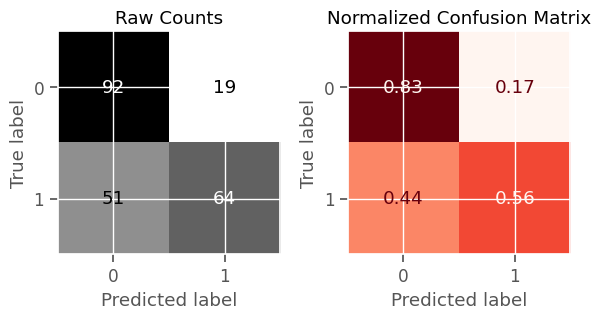


- Evaluating Test Data:
8/8 [==============================] - 5s 654ms/step - loss: 0.8762 - accuracy: 0.6903
{'loss': 0.8761825561523438, 'accuracy': 0.6902654767036438}


In [58]:
# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

In [59]:
# raise Exception("Add model fpaths to filepaths.json first and then use those below:")

#### Saving Model 1

In [60]:
# Saving model in tf format 
fname_model_lstm = FPATHS['models']['nn']['LSTM']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
lstm_model.save(fname_model_lstm, save_format='tf')

INFO:tensorflow:Assets written to: Models/keras/lstm/assets


INFO:tensorflow:Assets written to: Models/keras/lstm/assets


In [61]:
## Loading the Model
loaded_network = tf.keras.models.load_model(fname_model_lstm)
loaded_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 600)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 600, 100)          2413200   
                                                                 
 bidirectional (Bidirectiona  (None, 600, 256)         234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 600, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                        

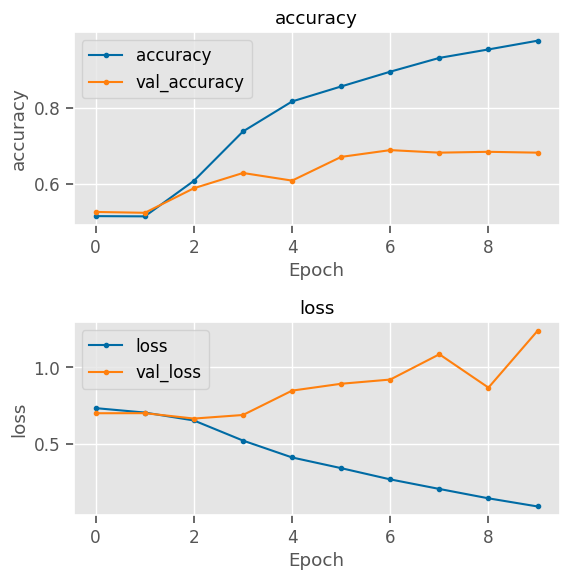


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       782
           1       0.97      0.93      0.95       790

    accuracy                           0.95      1572
   macro avg       0.95      0.95      0.95      1572
weighted avg       0.95      0.95      0.95      1572



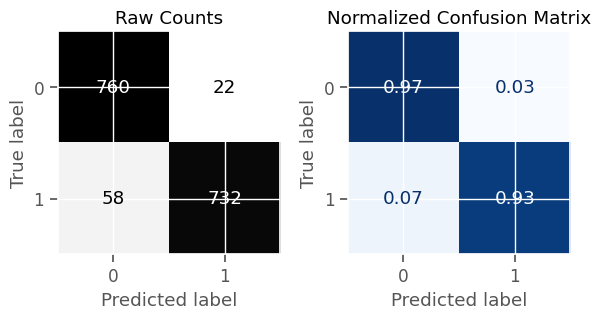


- Evaluating Training Data:
50/50 [==============================] - 28s 546ms/step - loss: 0.1503 - accuracy: 0.9491
{'loss': 0.15031781792640686, 'accuracy': 0.9491094350814819}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       111
           1       0.77      0.56      0.65       115

    accuracy                           0.69       226
   macro avg       0.71      0.69      0.69       226
weighted avg       0.71      0.69      0.68       226



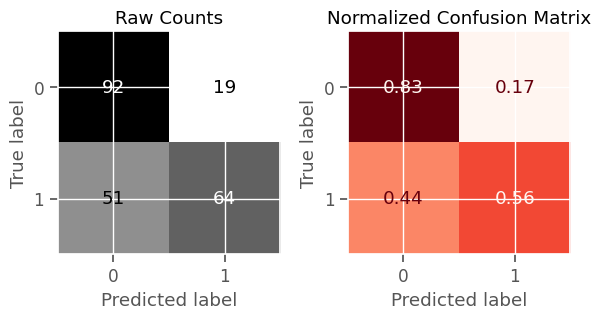


- Evaluating Test Data:
8/8 [==============================] - 4s 500ms/step - loss: 0.8762 - accuracy: 0.6903
{'loss': 0.8761825561523438, 'accuracy': 0.6902654767036438}


In [63]:
# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    loaded_network, X_train=train_ds, 
    X_test=test_ds, history=history
);

## Testing Saving/Loading Dataset Objects

### RNN Model 2

In [64]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=MAX_TOKENS,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 600)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 600, 100)          2413200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 600, 256)         176640    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                      

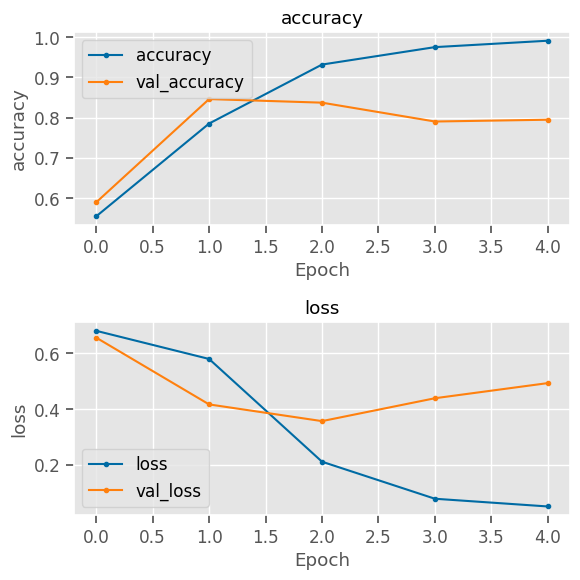


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       782
           1       0.93      0.95      0.94       790

    accuracy                           0.94      1572
   macro avg       0.94      0.94      0.94      1572
weighted avg       0.94      0.94      0.94      1572



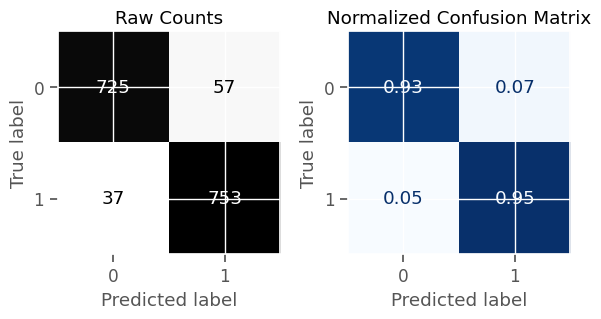


- Evaluating Training Data:
50/50 [==============================] - 5s 95ms/step - loss: 0.2896 - accuracy: 0.9402
{'loss': 0.289605051279068, 'accuracy': 0.9402035474777222}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       111
           1       0.80      0.83      0.81       115

    accuracy                           0.81       226
   macro avg       0.81      0.80      0.81       226
weighted avg       0.81      0.81      0.81       226



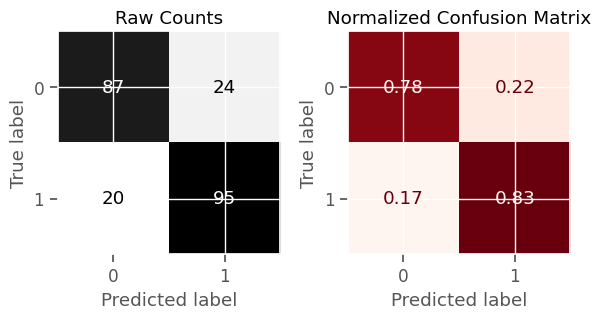


- Evaluating Test Data:
8/8 [==============================] - 1s 86ms/step - loss: 0.4313 - accuracy: 0.8053
{'loss': 0.43132859468460083, 'accuracy': 0.8053097128868103}


In [65]:
EMBED_DIM = 100
classes = y_train.unique()
MAX_TOKENS = sequence_vectorizer.vocabulary_size()
# Build the lstm model and specify the vectorizer
bidirection_model = build_gru_model_bi_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = bidirection_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    bidirection_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

In [66]:
# Saving model in tf format 
fname_model_gru = FPATHS['models']['nn']['GRU']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
bidirection_model.save(fname_model_gru, save_format='tf')

INFO:tensorflow:Assets written to: Models/keras/gru/assets


INFO:tensorflow:Assets written to: Models/keras/gru/assets


### Saving Tensorflow Datasets and Best Model